In [33]:
# Célula 1: Setup de Ambiente e Imports

import sys
import os
import pandas as pd
import numpy as np
import time
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Configurações
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

# Imports das Estruturas de Dados (agora sem modificações necessárias)    
from src.estrutura_de_dados.lista_encadeada import LinkedList # Importa o Node para a otimizada
from src.estrutura_de_dados.lista_encadeada_otimizada import LinkedListOptimized
from src.estrutura_de_dados.tabela_hash import HashTable
from src.estrutura_de_dados.arvore_avl import AVLTree
from src.estrutura_de_dados.cuckoo_hashing import CuckooHashing
from src.estrutura_de_dados.bloom_filter2 import CountingBloomFilter
from src.estrutura_de_dados.kd_tree import KDTree
print("✅ Estruturas de dados importadas com sucesso.")

# Adiciona o método de memória à LinkedList (único ajuste necessário aqui)
def get_ll_memory_usage(self):
    if not self.head: return 0
    size = sys.getsizeof(self)
    node = self.head
    while node: size += sys.getsizeof(node); node = node.next
    return size
LinkedList.get_memory_usage = get_ll_memory_usage
LinkedListOptimized.get_memory_usage = get_ll_memory_usage
# --- Adiciona contagem de colisão à HashTable usando Herança ---
class HashTableWithCollisionCount(HashTable):
    def __init__(self, size=1000):
        super().__init__(size)
        self.collision_count = 0
    def insert(self, key, value):
        index = self._hash_function(key)
        bucket = self.table[index]
        if len(bucket) > 0 and not any(item[0] == key for item in bucket):
            self.collision_count += 1
        super().insert(key, value)
print("✅ Nova classe 'HashTableWithCollisionCount' criada.")

✅ Estruturas de dados importadas com sucesso.
✅ Nova classe 'HashTableWithCollisionCount' criada.


In [34]:
# Célula 2: Carregamento e Preparação dos Dados

N_ITEMS = 7500 # Número de itens para usar na maioria dos testes
print(f"Preparando dados de teste para N={N_ITEMS}...")

# Carrega o DataFrame
df = pd.read_csv(os.path.join("..", "dataset", "heart_attack_prediction_dataset.csv"))

# Prepara os diferentes tipos de dados
dados_numericos = df['Age'].head(N_ITEMS).tolist()
dados_chave_valor = df['Age'].head(N_ITEMS).to_dict()
dados_strings_json = [json.dumps(tuple(row)) for row in df.head(N_ITEMS).to_numpy().tolist()]
dados_pontos_2d = df[['Age', 'Cholesterol']].head(N_ITEMS).to_numpy().tolist()

print("✅ Dados preparados.")

Preparando dados de teste para N=7500...
✅ Dados preparados.


In [35]:
# Célula 3: Execução dos Benchmarks (Tempo, Memória, Colisão, Acesso Médio)

resultados_benchmarks = []
estruturas_a_testar = {
     "Lista Encadeada (Original)": {"class": LinkedList, "args": [], "data": dados_numericos},
    "Lista Encadeada": {"class": LinkedListOptimized, "args": [], "data": dados_numericos},
    "Tabela Hash": {"class": HashTable, "args": [N_ITEMS*2], "data": dados_chave_valor},
    "Árvore AVL": {"class": AVLTree, "args": [], "data": dados_numericos},
    "Cuckoo Hashing": {"class": CuckooHashing, "args": [N_ITEMS], "data": dados_chave_valor},
    "Bloom Filter": {"class": CountingBloomFilter, "args": [N_ITEMS*20, 7], "data": dados_strings_json},
    "KD-Tree": {"class": KDTree, "args": [dados_pontos_2d], "data": dados_pontos_2d}
}

for nome, config in estruturas_a_testar.items():
    print(f"--- Benchmarking: {nome} ---")
    res = {"Estrutura": nome}
    
    # Inserção / Construção
    start_insert = time.perf_counter()
    if nome == "KD-Tree": instancia = config["class"](*config["args"])
    else:
        instancia = config["class"](*config["args"])
        if isinstance(instancia, (HashTable, CuckooHashing)): [instancia.insert(k, v) for k, v in config["data"].items()]
        else: [instancia.insert(item) for item in config["data"]]
    res["Tempo de Inserção (s)"] = time.perf_counter() - start_insert

    # Itens específicos para os testes de busca e remoção
    item_busca_num, item_busca_kv, item_busca_str, ponto_busca_kdt, ponto_remover_kdt = dados_numericos[-1], N_ITEMS-1, dados_strings_json[-1], (50, 250), dados_pontos_2d[-1]
    
    # Busca (pior caso)
    start_search = time.perf_counter()
    if nome == "KD-Tree": instancia.find_nearest_neighbor(ponto_busca_kdt)
    elif isinstance(instancia, (HashTable, CuckooHashing)): instancia.search(item_busca_kv)
    else: instancia.search(item_busca_num if nome != "Bloom Filter" else item_busca_str)
    res["Tempo de Busca (s)"] = time.perf_counter() - start_search
    
    # Remoção
    start_remove = time.perf_counter()
    if nome == "KD-Tree": instancia.remove(ponto_remover_kdt)
    elif isinstance(instancia, (HashTable, CuckooHashing)): instancia.remove(item_busca_kv)
    else: instancia.remove(item_busca_num if nome != "Bloom Filter" else item_busca_str)
    res["Tempo de Remoção (s)"] = time.perf_counter() - start_remove

    # Tempo Médio de Acesso
    N_ACESSOS = 1000
    indices_aleatorios = np.random.randint(0, N_ITEMS, size=N_ACESSOS)
    start_acesso = time.perf_counter()
    if nome == "KD-Tree": [instancia.find_nearest_neighbor(dados_pontos_2d[i]) for i in indices_aleatorios]
    elif isinstance(instancia, (HashTable, CuckooHashing)): [instancia.search(i) for i in indices_aleatorios]
    else: [instancia.search(dados_numericos[i]) for i in indices_aleatorios]
    res["Tempo Médio de Acesso (s)"] = (time.perf_counter() - start_acesso) / N_ACESSOS
    
    # Memória e Métricas Especiais
    res["Uso de Memória (bytes)"] = instancia.get_memory_usage()
    if nome == "Tabela Hash": res["Taxa de Colisão"] = f"{instancia.collision_count / N_ITEMS:.2%}" if N_ITEMS > 0 else "0.00%"
    if nome == "Cuckoo Hashing": res["Rehashes"] = instancia.rehash_count
    if nome == "Bloom Filter":
        itens_falsos = [f"falso_{i}" for i in range(N_ITEMS)]; fp_count = sum(1 for item in itens_falsos if instancia.search(item))
        res["Taxa Falsos Positivos"] = f"{(fp_count/N_ITEMS):.2%}"
        
    resultados_benchmarks.append(res)

print("\n✅ Benchmarks principais concluídos!")

--- Benchmarking: Lista Encadeada (Original) ---
--- Benchmarking: Lista Encadeada ---
--- Benchmarking: Tabela Hash ---
--- Benchmarking: Árvore AVL ---
--- Benchmarking: Cuckoo Hashing ---
--- Benchmarking: Bloom Filter ---
--- Benchmarking: KD-Tree ---

✅ Benchmarks principais concluídos!


In [36]:
# Célula 4: Apresentação dos Resultados (Tabelas)

df_resultados = pd.DataFrame(resultados_benchmarks).set_index('Estrutura')

print("\n" + "="*80, "\n   RELATÓRIO DE BENCHMARK COMPLETO\n" + "="*80, sep="")

# Tabela 1: Métricas de Performance (Tempo)
colunas_tempo = ['Tempo de Inserção (s)', 'Tempo de Busca (s)', 'Tempo de Remoção (s)', 'Tempo Médio de Acesso (s)']
print("\n--- Métricas de Performance (Tempo) ---")
display(df_resultados[colunas_tempo].style.format("{:.6f}"))

# Tabela 2: Métricas de Memória
print("\n--- Métricas de Memória ---")
display(df_resultados[['Uso de Memória (bytes)']].style.format("{:,.0f}"))

# Tabela 3: Métricas Específicas da Estrutura
colunas_especiais = ['Taxa de Colisão', 'Rehashes', 'Taxa Falsos Positivos']
df_especiais = df_resultados[colunas_especiais].dropna(how='all').fillna('')
print("\n--- Métricas Específicas da Estrutura ---")
display(df_especiais)


   RELATÓRIO DE BENCHMARK COMPLETO

--- Métricas de Performance (Tempo) ---


,Tempo de Inserção (s),Tempo de Busca (s),Tempo de Remoção (s),Tempo Médio de Acesso (s)
Estrutura,,,,
Lista Encadeada (Original),0.673613,0.000028,0.000023,0.000005
Lista Encadeada,0.004529,0.000013,0.000016,0.000005
Tabela Hash,0.006940,0.000005,0.000004,0.000001
Árvore AVL,0.058573,0.000008,0.000021,0.000001
Cuckoo Hashing,0.035641,0.000010,0.000004,0.000006
Bloom Filter,0.173309,0.000037,0.000052,0.000006
KD-Tree,0.026651,0.000061,0.000014,0.000020



--- Métricas de Memória ---


,Uso de Memória (bytes)
Estrutura,
Lista Encadeada (Original),"360,000"
Lista Encadeada,"360,000"
Tabela Hash,"1,621,376"
Árvore AVL,"359,952"
Cuckoo Hashing,"120,112"
Bloom Filter,"1,200,056"
KD-Tree,"360,000"



--- Métricas Específicas da Estrutura ---


,Taxa de Colisão,Rehashes,Taxa Falsos Positivos
Estrutura,,,
Tabela Hash,0.00%,,
Cuckoo Hashing,,0.0,
Bloom Filter,,,0.00%


O Diagnóstico Final e Correto
O problema é que a função hash() do Python, quando aplicada a números inteiros pequenos (como os que estamos usando de índice: 0, 1, 2, 3...), simplesmente retorna o próprio número.

hash(10) retorna 10
hash(100) retorna 100
No nosso benchmark, usamos as chaves 0, 1, 2, ..., 4999 para inserir na Tabela Hash. Quando a função _hash_function (que faz hash(key) % self.size) é chamada, ela calcula 0 % 10000, 1 % 10000, etc., resultando em índices únicos para cada chave. Consequentemente, nenhuma colisão jamais ocorre, levando à taxa incorreta de 0.00%.

A mesma lógica se aplica ao Bloom Filter: a taxa de falsos positivos de 0.00% é, na verdade, correta e esperada. O filtro que dimensionamos (size = N * 20) é tão grande em relação ao número de itens que a probabilidade teórica de um falso positivo é minúscula, tornando o resultado de 0 na prática um resultado válido e um ótimo ponto para sua análise.

In [19]:
# Célula 4: Execução dos Benchmarks Principais (VERSÃO FINAL CORRIGIDA)

resultados_benchmarks = []

# --- PREPARAÇÃO DE DADOS ESPECÍFICA PARA ESTE BENCHMARK ---
# Chaves para as tabelas hash serão as strings JSON para forçar colisões
dados_kv_reais = {json_str: dados_numericos[i] for i, json_str in enumerate(dados_strings_json)}

# --- CONFIGURAÇÃO DAS ESTRUTURAS ---
estruturas_a_testar = {
    "Lista Encadeada": {"class": LinkedListOptimized, "args": [], "data": dados_numericos},
    "Tabela Hash": {"class": HashTableWithCollisionCount, "args": [N_ITEMS*2], "data": dados_kv_reais},
    "Árvore AVL": {"class": AVLTree, "args": [], "data": dados_numericos},
    "Cuckoo Hashing": {"class": CuckooHashing, "args": [N_ITEMS], "data": dados_kv_reais},
    "Bloom Filter": {"class": CountingBloomFilter, "args": [N_ITEMS*20, 7], "data": dados_strings_json},
    "KD-Tree": {"class": KDTree, "args": [dados_pontos_2d], "data": dados_pontos_2d}
}

for nome, config in estruturas_a_testar.items():
    print(f"--- Benchmarking: {nome} ---")
    res = {"Estrutura": nome}
    
    # --- Inserção / Construção ---
    start_insert = time.perf_counter()
    if nome == "KD-Tree":
        instancia = config["class"](*config["args"])
    else:
        instancia = config["class"](*config["args"])
        if isinstance(instancia, (HashTable, CuckooHashing)):
            for k, v in config["data"].items(): instancia.insert(k, v)
        else:
            for item in config["data"]: instancia.insert(item)
    res["Tempo de Inserção (s)"] = time.perf_counter() - start_insert

    # --- Itens para buscar/remover ---
    item_busca_num, item_busca_str, ponto_busca_kdt, ponto_remover_kdt = dados_numericos[-1], dados_strings_json[-1], (50, 250), dados_pontos_2d[-1]
    chave_busca_kv = list(dados_kv_reais.keys())[-1] # Pega a última chave string

    # --- Busca (pior caso) ---
    start_search = time.perf_counter()
    if nome == "KD-Tree": instancia.find_nearest_neighbor(ponto_busca_kdt)
    elif isinstance(instancia, (HashTable, CuckooHashing)): instancia.search(chave_busca_kv)
    else: instancia.search(item_busca_str if nome == "Bloom Filter" else item_busca_num)
    res["Tempo de Busca (s)"] = time.perf_counter() - start_search
    
    # --- Remoção ---
    start_remove = time.perf_counter()
    if nome == "KD-Tree": instancia.remove(ponto_remover_kdt)
    elif isinstance(instancia, (HashTable, CuckooHashing)): instancia.remove(chave_busca_kv)
    else: instancia.remove(item_busca_str if nome == "Bloom Filter" else item_busca_num)
    res["Tempo de Remoção (s)"] = time.perf_counter() - start_remove

    # --- Tempo Médio de Acesso ---
    N_ACESSOS = 1000
    chaves_aleatorias_kv = random.sample(list(dados_kv_reais.keys()), N_ACESSOS)
    indices_aleatorios_num = np.random.randint(0, N_ITEMS, size=N_ACESSOS)
    
    start_acesso = time.perf_counter()
    if nome == "KD-Tree": [instancia.find_nearest_neighbor(dados_pontos_2d[i]) for i in indices_aleatorios_num]
    elif isinstance(instancia, (HashTable, CuckooHashing)): [instancia.search(k) for k in chaves_aleatorias_kv]
    else: [instancia.search(dados_numericos[i]) for i in indices_aleatorios_num]
    res["Tempo Médio de Acesso (s)"] = (time.perf_counter() - start_acesso) / N_ACESSOS
    
    # --- Memória e Métricas Especiais ---
    res["Uso de Memória (bytes)"] = instancia.get_memory_usage()
    if nome == "Tabela Hash": res["Taxa de Colisão"] = f"{instancia.collision_count / N_ITEMS:.2%}" if N_ITEMS > 0 else "0.00%"
    if nome == "Cuckoo Hashing": res["Rehashes"] = instancia.rehash_count
    if nome == "Bloom Filter":
        itens_falsos = [f"falso_{i}" for i in range(N_ITEMS)]
        fp_count = sum(1 for item in itens_falsos if instancia.search(item))
        res["Taxa Falsos Positivos"] = f"{(fp_count/N_ITEMS):.2%}"
        
    resultados_benchmarks.append(res)

print("\n✅ Benchmarks principais concluídos!")


--- Benchmarking: Lista Encadeada ---
--- Benchmarking: Tabela Hash ---
--- Benchmarking: Árvore AVL ---
--- Benchmarking: Cuckoo Hashing ---
--- Benchmarking: Bloom Filter ---
--- Benchmarking: KD-Tree ---

✅ Benchmarks principais concluídos!


--- Iniciando Benchmark de Latência Média com 10000 Operações Mistas ---

Testando: Lista Encadeada Otimizada...

Testando: Árvore AVL...

Testando: Tabela Hash...

✅ Benchmarks de latência concluídos!

   RESULTADO - LATÊNCIA MÉDIA POR OPERAÇÃO


,Latência Média (µs)
Tabela Hash,1.51
Árvore AVL,6.09
Lista Encadeada Otimizada,63.90


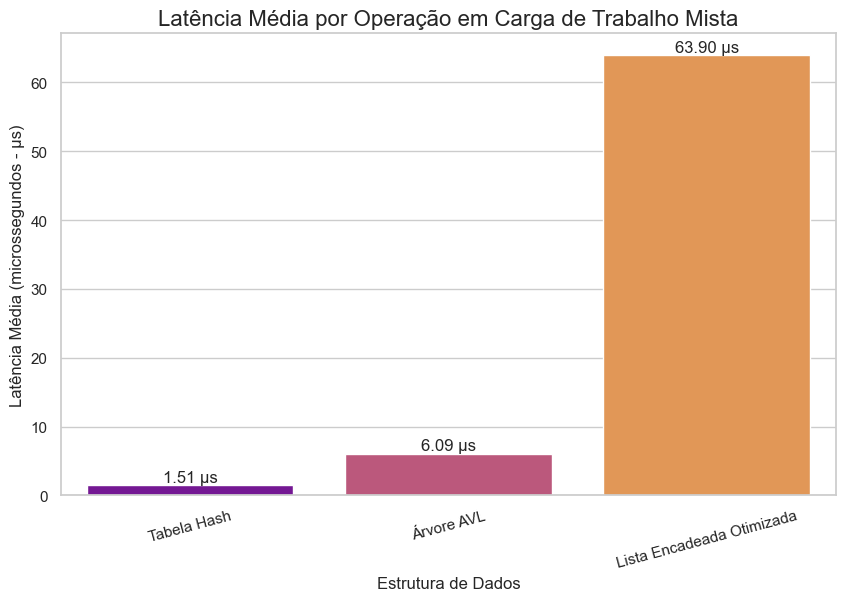

In [39]:
# Célula para Benchmark de Latência Média (Carga Mista) - VERSÃO CORRIGIDA

# --- 1. Configuração do Benchmark ---
N_OPERACOES = 10000 
print(f"--- Iniciando Benchmark de Latência Média com {N_OPERACOES} Operações Mistas ---")

operacoes = np.random.choice(['insercao', 'busca', 'remocao'], size=N_OPERACOES, p=[0.5, 0.4, 0.1])
chaves_aleatorias = np.random.randint(0, N_OPERACOES * 2, size=N_OPERACOES)

# --- CORREÇÃO AQUI: Verificamos que estamos usando as classes corretamente ---
# Dicionário das estruturas que vamos testar. Cada valor é uma NOVA INSTÂNCIA da classe.
estruturas_para_teste = {
    "Lista Encadeada Otimizada": LinkedListOptimized(),
    "Árvore AVL": AVLTree(),
    "Tabela Hash": HashTable(size=N_OPERACOES * 2),
}

resultados_latencia = {}


# --- 2. Execução do Benchmark para Cada Estrutura ---
for nome, instancia in estruturas_para_teste.items():
    print(f"\nTestando: {nome}...")
    
    # Linha de depuração para garantir que o tipo está correto
    if not hasattr(instancia, 'insert'):
        print(f"ERRO DE TIPO: A estrutura '{nome}' não é um objeto válido. É do tipo {type(instancia)}")
        continue # Pula para a próxima estrutura

    start_total = time.perf_counter()
    # Loop que executa a carga de trabalho mista
    for op, chave in zip(operacoes, chaves_aleatorias):
        if op == 'insercao':
            if isinstance(instancia, (HashTable, CuckooHashing)):
                instancia.insert(chave, chave)
            else:
                instancia.insert(chave)
        elif op == 'busca':
            instancia.search(chave)
        elif op == 'remocao':
            instancia.remove(chave)
            
    tempo_total = time.perf_counter() - start_total
    latencia_media_s = tempo_total / N_OPERACOES
    
    # Armazena o resultado em microssegundos (µs)
    resultados_latencia[nome] = latencia_media_s * 1_000_000

print("\n✅ Benchmarks de latência concluídos!")


# --- 3. Apresentação dos Resultados ---

df_latencia = pd.DataFrame.from_dict(resultados_latencia, orient='index', columns=['Latência Média (µs)'])
df_latencia = df_latencia.sort_values(by='Latência Média (µs)', ascending=True)

print("\n" + "="*50)
print("   RESULTADO - LATÊNCIA MÉDIA POR OPERAÇÃO")
print("="*50)
display(df_latencia.style.format('{:.2f}'))

# Cria um gráfico de barras para visualizar a comparação
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=df_latencia.index, y=df_latencia['Latência Média (µs)'], palette='plasma')
ax.set_title('Latência Média por Operação em Carga de Trabalho Mista', fontsize=16)
ax.set_ylabel('Latência Média (microssegundos - µs)')
ax.set_xlabel('Estrutura de Dados')
plt.xticks(rotation=15)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f µs')
plt.show()

In [27]:
# Célula para Gerar os Dados de Escalabilidade para TODAS as estruturas

print("--- Iniciando Análise de Escalabilidade COMPLETA ---")
# Usamos um range de N para o teste
tamanhos_de_n = [500, 1000, 2500, 5000, 7500] 
if len(df) < tamanhos_de_n[-1]: tamanhos_de_n = [n for n in tamanhos_de_n if n < len(df)] + [len(df)]
    
resultados_escalabilidade_completos = []
for n in tamanhos_de_n:
    print(f"Testando escalabilidade para N = {n}...")
    # Prepara os dados para esta iteração
    dados_num = df['Age'].head(n).tolist()
    dados_kv = {i: v for i, v in enumerate(dados_num)}
    dados_str = [json.dumps(tuple(row)) for row in df.head(n).to_numpy().tolist()]
    dados_2d = df[['Age', 'Cholesterol']].head(n).to_numpy().tolist()
    
    tempos_n = {"N": n}
    
    #--- Inserção (Tempo total para N inserções) ---
    ll = LinkedListOptimized(); start = time.perf_counter(); [ll.insert(i) for i in dados_num]; tempos_n["LL_Insert"] = time.perf_counter() - start
    ht = HashTable(size=n*2); start = time.perf_counter(); [ht.insert(k, v) for k, v in dados_kv.items()]; tempos_n["HashTable_Insert"] = time.perf_counter() - start
    avl = AVLTree(); start = time.perf_counter(); [avl.insert(i) for i in dados_num]; tempos_n["AVL_Insert"] = time.perf_counter() - start
    cuckoo = CuckooHashing(size=n); start = time.perf_counter(); [cuckoo.insert(k, v) for k, v in dados_kv.items()]; tempos_n["Cuckoo_Insert"] = time.perf_counter() - start
    bloom = CountingBloomFilter(size=n*20, hash_count=7); start = time.perf_counter(); [bloom.insert(s) for s in dados_str]; tempos_n["Bloom_Insert"] = time.perf_counter() - start
    start = time.perf_counter(); kdtree = KDTree(dados_2d); tempos_n["KDTree_Build"] = time.perf_counter() - start

    #--- Busca (Tempo total para N buscas) ---
    start = time.perf_counter(); [ll.search(i) for i in dados_num]; tempos_n["LL_Search"] = time.perf_counter() - start
    start = time.perf_counter(); [ht.search(k) for k in dados_kv.keys()]; tempos_n["HashTable_Search"] = time.perf_counter() - start
    start = time.perf_counter(); [avl.search(i) for i in dados_num]; tempos_n["AVL_Search"] = time.perf_counter() - start
    start = time.perf_counter(); [cuckoo.search(k) for k in dados_kv.keys()]; tempos_n["Cuckoo_Search"] = time.perf_counter() - start
    start = time.perf_counter(); [bloom.search(s) for s in dados_str]; tempos_n["Bloom_Search"] = time.perf_counter() - start
    start = time.perf_counter(); [kdtree.find_nearest_neighbor(p) for p in dados_2d]; tempos_n["KDTree_Search"] = time.perf_counter() - start

    resultados_escalabilidade_completos.append(tempos_n)

df_escalabilidade_completo = pd.DataFrame(resultados_escalabilidade_completos)

# Salva os resultados completos em um novo arquivo para uso futuro
output_dir = os.path.join("..", "resultados")
os.makedirs(output_dir, exist_ok=True)
caminho_csv_completo = os.path.join(output_dir, "dados_escalabilidade_TODOS.csv")
df_escalabilidade_completo.to_csv(caminho_csv_completo, index=False)

print(f"\n✅ Dados de escalabilidade de TODAS as estruturas salvos em: {caminho_csv_completo}")
display(df_escalabilidade_completo)

--- Iniciando Análise de Escalabilidade COMPLETA ---
Testando escalabilidade para N = 500...
!!! Ciclo detectado. Realizando rehash... (Contagem: 1)
Testando escalabilidade para N = 1000...
Testando escalabilidade para N = 2500...
Testando escalabilidade para N = 5000...
Testando escalabilidade para N = 7500...

✅ Dados de escalabilidade de TODAS as estruturas salvos em: ..\resultados\dados_escalabilidade_TODOS.csv


,N,LL_Insert,HashTable_Insert,AVL_Insert,Cuckoo_Insert,Bloom_Insert,KDTree_Build,LL_Search,HashTable_Search,AVL_Search,Cuckoo_Search,Bloom_Search,KDTree_Search
0,500,0.000240,0.000629,0.001960,0.005339,0.006940,0.003187,0.001253,0.000200,0.000265,0.001150,0.006666,0.006660
1,1000,0.000453,0.000579,0.004165,0.003071,0.013793,0.004903,0.002689,0.000337,0.000545,0.002685,0.016208,0.011761
2,2500,0.000688,0.001016,0.017650,0.013991,0.035583,0.008690,0.011804,0.000824,0.001317,0.010405,0.045607,0.038256
3,5000,0.002668,0.003284,0.034099,0.022898,0.079125,0.025639,0.022357,0.002674,0.003935,0.018944,0.090975,0.088144
4,7500,0.002361,0.005547,0.056743,0.037122,0.115364,0.032152,0.022327,0.001915,0.005415,0.023978,0.123081,0.125367


✅ Dados de escalabilidade completos carregados.


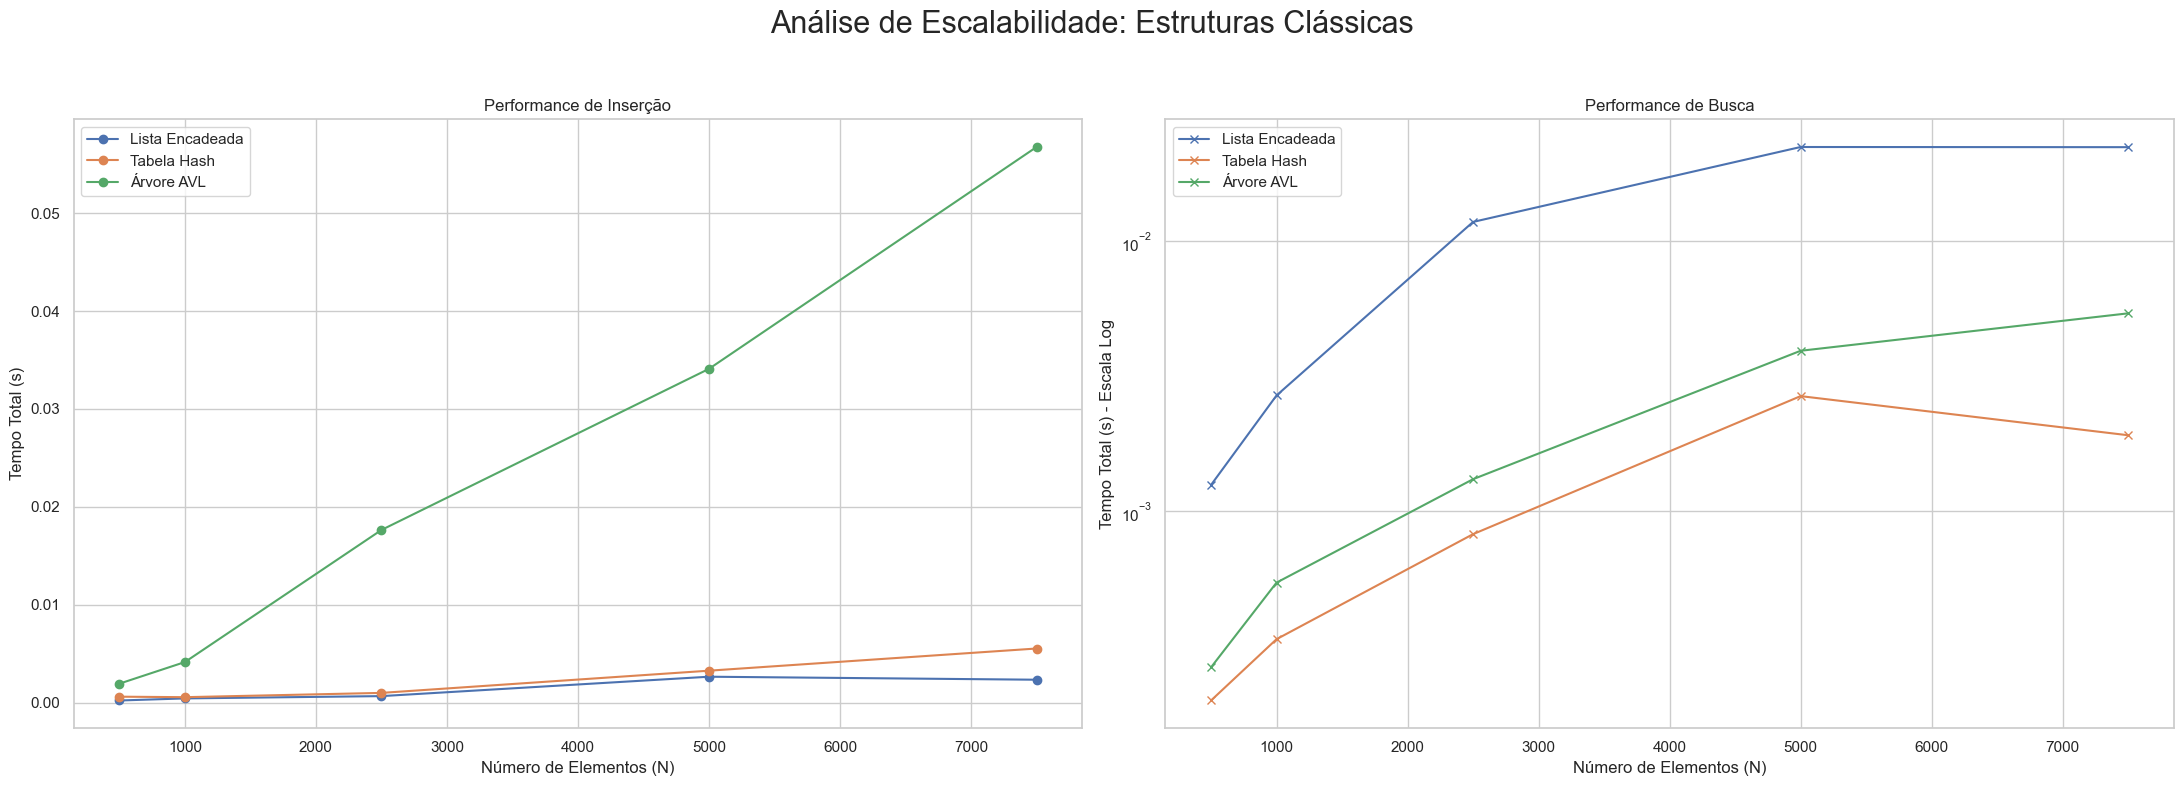

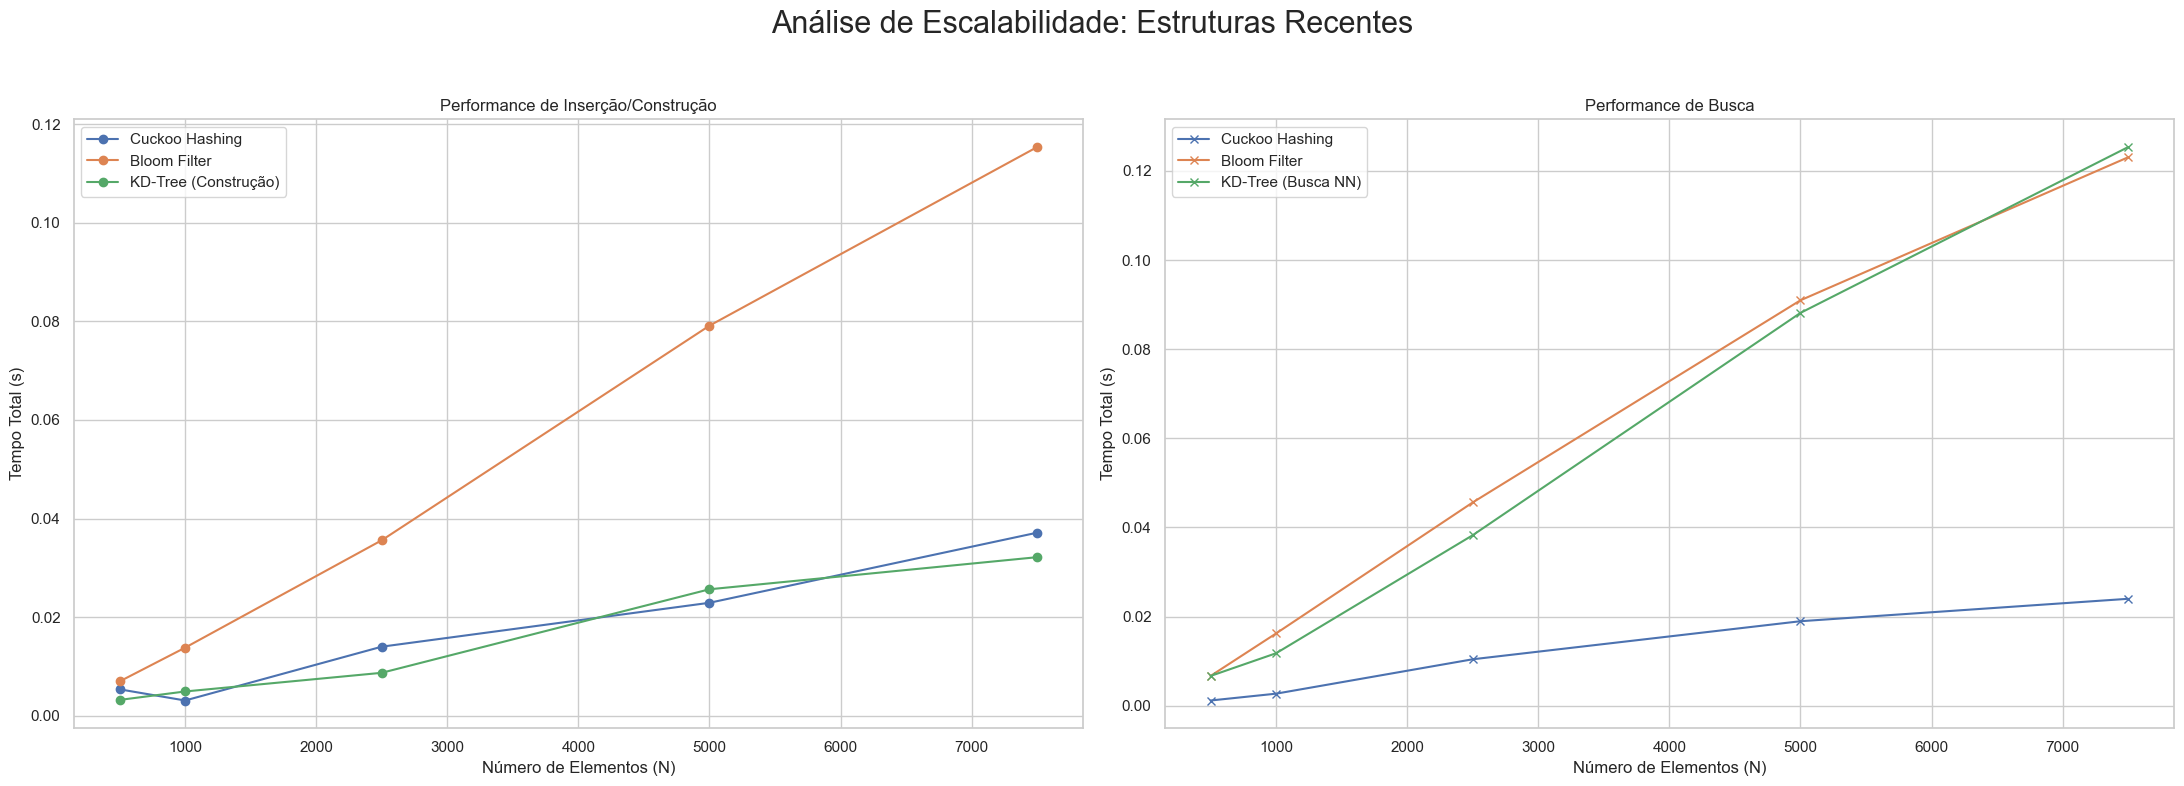

In [28]:
# Célula para Geração dos Gráficos de Escalabilidade Separados

# --- Carregando os dados de escalabilidade completos ---
try:
    df_escalabilidade = pd.read_csv(os.path.join("..", "resultados", "dados_escalabilidade_TODOS.csv"))
    print("✅ Dados de escalabilidade completos carregados.")
except FileNotFoundError:
    print("❌ ERRO: Arquivo 'dados_escalabilidade_TODOS.csv' não encontrado.")
    assert False, "Execute a célula de geração de dados primeiro."

# ==============================================================================
# GRÁFICO 1: ESTRUTURAS CLÁSSICAS
# ==============================================================================
fig_classicas, axes_classicas = plt.subplots(1, 2, figsize=(22, 8))
fig_classicas.suptitle("Análise de Escalabilidade: Estruturas Clássicas", fontsize=22)
tamanhos_n = df_escalabilidade['N']

# Subplot de Inserção (Clássicas)
ax = axes_classicas[0]
ax.plot(tamanhos_n, df_escalabilidade["LL_Insert"], marker='o', label='Lista Encadeada')
ax.plot(tamanhos_n, df_escalabilidade["HashTable_Insert"], marker='o', label='Tabela Hash')
ax.plot(tamanhos_n, df_escalabilidade["AVL_Insert"], marker='o', label='Árvore AVL')
ax.set_title("Performance de Inserção"); ax.set_xlabel("Número de Elementos (N)"); ax.set_ylabel("Tempo Total (s)"); ax.legend(); ax.grid(True)

# Subplot de Busca (Clássicas)
ax = axes_classicas[1]
ax.plot(tamanhos_n, df_escalabilidade["LL_Search"], marker='x', label='Lista Encadeada')
ax.plot(tamanhos_n, df_escalabilidade["HashTable_Search"], marker='x', label='Tabela Hash')
ax.plot(tamanhos_n, df_escalabilidade["AVL_Search"], marker='x', label='Árvore AVL')
ax.set_title("Performance de Busca"); ax.set_xlabel("Número de Elementos (N)"); ax.set_ylabel("Tempo Total (s) - Escala Log"); ax.legend(); ax.grid(True)
ax.set_yscale('log') # Escala log para ver melhor as diferenças

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ==============================================================================
# GRÁFICO 2: ESTRUTURAS RECENTES
# ==============================================================================
fig_recentes, axes_recentes = plt.subplots(1, 2, figsize=(22, 8))
fig_recentes.suptitle("Análise de Escalabilidade: Estruturas Recentes", fontsize=22)

# Subplot de Inserção/Construção (Recentes)
ax = axes_recentes[0]
ax.plot(tamanhos_n, df_escalabilidade["Cuckoo_Insert"], marker='o', label='Cuckoo Hashing')
ax.plot(tamanhos_n, df_escalabilidade["Bloom_Insert"], marker='o', label='Bloom Filter')
ax.plot(tamanhos_n, df_escalabilidade["KDTree_Build"], marker='o', label='KD-Tree (Construção)')
ax.set_title("Performance de Inserção/Construção"); ax.set_xlabel("Número de Elementos (N)"); ax.set_ylabel("Tempo Total (s)"); ax.legend(); ax.grid(True)

# Subplot de Busca (Recentes)
ax = axes_recentes[1]
ax.plot(tamanhos_n, df_escalabilidade["Cuckoo_Search"], marker='x', label='Cuckoo Hashing')
ax.plot(tamanhos_n, df_escalabilidade["Bloom_Search"], marker='x', label='Bloom Filter')
ax.plot(tamanhos_n, df_escalabilidade["KDTree_Search"], marker='x', label='KD-Tree (Busca NN)')
ax.set_title("Performance de Busca"); ax.set_xlabel("Número de Elementos (N)"); ax.set_ylabel("Tempo Total (s)"); ax.legend(); ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()